In [1]:
# === SEKCJA 1: IMPORT I KONFIGURACJA ===
import pandas as pd
import numpy as np
import re
import warnings

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense, Dropout, BatchNormalization, Bidirectional, LeakyReLU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2 # ZMIANA: Import regularyzacji L2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython.display import display
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

print("Wczytywanie danych...")
try:
    df_main_raw = pd.read_csv('saleflats_mazowieckie_c.csv', sep=',', header=None, on_bad_lines='skip', low_memory=False)
    df_slownik = pd.read_csv('slownik_finalny_zweryfikowany.csv', sep=';')
    print("Wszystkie pliki wczytane.")
except FileNotFoundError:
    print("BŁĄD: Upewnij się, że pliki 'saleflats_mazowieckie_c.csv' i 'slownik_finalny_zweryfikowany.csv' znajdują się w folderze.")
    raise

Wczytywanie danych...
Wszystkie pliki wczytane.


In [2]:
# === SEKCJA 2: PRZYGOTOWANIE DANYCH ===
print("--- Nadawanie nazw kolumnom ---")
df_main = df_main_raw.copy()
original_cols_names = [i for i in range(53)]
new_id_cols = ['WojewodztwoID', 'PowiatID', 'GminaID', 'RodzajGminyID', 'MiastoID', 'DzielnicaID', 'UlicaID']
df_main.columns = original_cols_names + new_id_cols
main_cols_map = {0: 'SaleId', 2: 'Location', 4: 'Description', 5: 'Area', 6: 'Price', 17: 'NumberOfRooms', 35: 'Floor', 36: 'Floors', 21: 'BuildingType'}
df_main.rename(columns=main_cols_map, inplace=True)

id_to_street_name_map = pd.Series(df_slownik.Nazwa.values, index=df_slownik.LocationID).to_dict()
print("Struktury danych przygotowane.")

print("\n--- Czyszczenie i filtrowanie ---")
numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors']
for col in numeric_features:
    df_main[col] = pd.to_numeric(df_main[col], errors='coerce')

df_main['UlicaID'] = pd.to_numeric(df_main['UlicaID'], errors='coerce').fillna(0).astype(int)
df_main.dropna(subset=['Description', 'UlicaID'] + numeric_features, inplace=True)
df_main = df_main[df_main['UlicaID'] != 0].copy()

# ZMIANA: Czyszczenie kluczowej, ale zaszumionej cechy 'BuildingType'
# Sprawdzamy, ile jest unikalnych wartości i jak często występują
building_type_counts = df_main['BuildingType'].value_counts()
print(f"Liczba unikalnych wartości w 'BuildingType' przed czyszczeniem: {len(building_type_counts)}")
# Ustawiamy próg, poniżej którego kategorie zostaną zgrupowane
MIN_COUNT_BUILDING_TYPE = 10
# Znajdujemy typy budynków, które występują rzadziej niż próg
types_to_replace = building_type_counts[building_type_counts < MIN_COUNT_BUILDING_TYPE].index
# Zastępujemy rzadkie typy etykietą 'inny'
df_main['BuildingType_Clean'] = df_main['BuildingType'].replace(types_to_replace, 'inny')
print(f"Liczba unikalnych wartości w 'BuildingType' po czyszczeniu: {df_main['BuildingType_Clean'].nunique()}")


MIN_SAMPLES_PER_STREET = 10 
street_counts = df_main['UlicaID'].value_counts()
streets_to_keep = street_counts[street_counts >= MIN_SAMPLES_PER_STREET].index
df_model_ready = df_main[df_main['UlicaID'].isin(streets_to_keep)].copy()

if df_model_ready.empty:
    raise ValueError(f"Po filtracji z MIN_SAMPLES_PER_STREET = {MIN_SAMPLES_PER_STREET} nie pozostały żadne dane.")

def clean_text(text): return re.sub(r'[^a-ząęółśżźćń ]', '', str(text).lower())
df_model_ready['description_clean'] = df_model_ready['Description'].apply(clean_text)

print(f"Finalny zbiór danych gotowy. Wiersze: {len(df_model_ready)}, Unikalnych ulic: {df_model_ready['UlicaID'].nunique()}")

--- Nadawanie nazw kolumnom ---
Struktury danych przygotowane.

--- Czyszczenie i filtrowanie ---
Liczba unikalnych wartości w 'BuildingType' przed czyszczeniem: 81325
Liczba unikalnych wartości w 'BuildingType' po czyszczeniu: 1
Finalny zbiór danych gotowy. Wiersze: 77940, Unikalnych ulic: 1454


In [3]:
# === SEKCJA 3: PRZYGOTOWANIE DANYCH WE/WY (INŻYNIERIA CECH I KODOWANIE) ===
MAX_WORDS, MAX_LEN = 20000, 250 # ZMIANA: Nieznacznie zwiększamy długość sekwencji
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
tokenizer.fit_on_texts(df_model_ready['description_clean'])
sequences = tokenizer.texts_to_sequences(df_model_ready['description_clean'])
X_text = pd.DataFrame(pad_sequences(sequences, maxlen=MAX_LEN), index=df_model_ready.index)

# ZMIANA: Dodajemy nową, potężną cechę - cenę za metr
df_model_ready['Price_per_sqm'] = df_model_ready['Price'] / df_model_ready['Area']
# Zastępujemy nieskończone wartości (gdyby Area=0) medianą
df_model_ready['Price_per_sqm'].replace([np.inf, -np.inf], np.nan, inplace=True)

numeric_features_updated = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors', 'Price_per_sqm']
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_numeric = pd.DataFrame(numeric_pipeline.fit_transform(df_model_ready[numeric_features_updated]), index=df_model_ready.index)

print("Kodowanie cech kategorycznych za pomocą Label Encoding...")
# ZMIANA: Używamy nowej, wyczyszczonej kolumny 'BuildingType_Clean'
categorical_features_to_embed = ['PowiatID', 'GminaID', 'MiastoID', 'DzielnicaID', 'BuildingType_Clean']
categorical_encoders = {}
X_categorical_encoded = pd.DataFrame(index=df_model_ready.index)

for col in categorical_features_to_embed:
    df_model_ready[col] = df_model_ready[col].astype(str).fillna('missing')
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(df_model_ready[col])
    categorical_encoders[col] = le

# Zmienna celu (y) - UlicaID
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_model_ready['UlicaID'])
y_encoded_series = pd.Series(y_encoded, index=df_model_ready.index)
num_classes = len(label_encoder.classes_)
print(f"Dane przygotowane do treningu. Liczba klas (UlicaID): {num_classes}")

# Podział na zbiory
X_train_idx, X_val_idx = train_test_split(df_model_ready.index, test_size=0.2, random_state=42, stratify=y_encoded)
X_train_text, X_val_text = X_text.loc[X_train_idx], X_text.loc[X_val_idx]
X_train_num, X_val_num = X_numeric.loc[X_train_idx], X_numeric.loc[X_val_idx]
X_train_cat, X_val_cat = X_categorical_encoded.loc[X_train_idx], X_categorical_encoded.loc[X_val_idx]
y_train, y_val = y_encoded_series.loc[X_train_idx], y_encoded_series.loc[X_val_idx]

Kodowanie cech kategorycznych za pomocą Label Encoding...
Dane przygotowane do treningu. Liczba klas (UlicaID): 1454


In [4]:
# === SEKCJA 4: BUDOWA I TRENING ULEPSZONEGO MODELU ===
from tensorflow.keras.layers import Reshape

# Wejścia modelu
input_text = Input(shape=(MAX_LEN,), name='text_input')
input_numeric = Input(shape=(X_numeric.shape[1],), name='numeric_input')
categorical_inputs = []
embedding_layers = []

# Tworzenie osobnego wejścia i warstwy Embedding dla każdej cechy kategorycznej
for col in categorical_features_to_embed:
    num_unique_values = len(categorical_encoders[col].classes_)
    # ZMIANA: Lepsza heurystyka dla wymiaru embeddingu
    embedding_dim = min(50, int(num_unique_values / 2) + 1)
    
    cat_input = Input(shape=(1,), name=f'input_{col}')
    categorical_inputs.append(cat_input)
    
    embedding = Embedding(input_dim=num_unique_values, output_dim=embedding_dim, name=f'embedding_{col}')(cat_input)
    embedding = Reshape(target_shape=(embedding_dim,))(embedding)
    embedding_layers.append(embedding)

# Gałąź tekstowa
text_embedding = Embedding(input_dim=MAX_WORDS, output_dim=128, name='text_embedding')(input_text)
# ZMIANA: Dodajemy regularyzację L2 do warstwy LSTM
lstm_layer = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(1e-4)))(text_embedding)

# Łączenie wszystkich cech
all_features = [lstm_layer, input_numeric] + embedding_layers
concatenated = Concatenate()(all_features)

# ZMIANA: Mniejsza, ale mocniej regularyzowana głowica klasyfikująca
x = Dense(256, kernel_regularizer=l2(1e-4))(concatenated)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x) # ZMIANA: Standardowy dropout

x = Dense(128, kernel_regularizer=l2(1e-4))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x) # ZMIANA: Standardowy dropout

output_layer = Dense(num_classes, activation='softmax', name='output_ulica')(x)

model = Model(inputs=[input_text, input_numeric] + categorical_inputs, outputs=output_layer)
# ZMIANA: Niższy learning rate dla stabilniejszego treningu
model.compile(optimizer=Adam(learning_rate=5e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Przygotowanie danych wejściowych w formie słownika
X_train_dict = {'text_input': X_train_text, 'numeric_input': X_train_num}
X_val_dict = {'text_input': X_val_text, 'numeric_input': X_val_num}
for col in categorical_features_to_embed:
    # Używamy nowej, czystej nazwy kolumny
    train_col_name = col if col != 'BuildingType_Clean' else 'BuildingType'
    X_train_dict[f'input_{col}'] = X_train_cat[col]
    X_val_dict[f'input_{col}'] = X_val_cat[col]

# ZMIANA: Zwiększamy cierpliwość, aby dać modelowi szansę
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1)
]

print("\nRozpoczynam trening ULEPSZONEJ sieci neuronowej...")
history = model.fit(
    X_train_dict, y_train, 
    validation_data=(X_val_dict, y_val), 
    epochs=50, # ZMIANA: Dajemy więcej epok, EarlyStopping i tak wybierze najlepszy moment
    batch_size=128, 
    callbacks=callbacks
)
model.save('final_embedding_predictor_v2.keras')

C:\Users\Ai\.conda\envs\projekt1\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 250)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_PowiatID (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_GminaID (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_MiastoID (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_DzielnicaID             │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_BuildingType_Clean      │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ text_embedding (Embedding)    │ (None, 250, 128)          │       2,560,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_PowiatID            │ (None, 1, 2)              │               6 │ input_PowiatID[0][0]       │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_GminaID (Embedding) │ (None, 1, 1)              │               1 │ input_GminaID[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_MiastoID            │ (None, 1, 10)             │             190 │ input_MiastoID[0][0]       │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_DzielnicaID         │ (None, 1, 50)             │           5,300 │ input_DzielnicaID[0][0]    │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_BuildingType_Clean  │ (None, 1, 1)              │               1 │ input_BuildingType_Clean[… │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 256)               │         263,168 │ text_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 6)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,134,376 (11.96 MB)

 Trainable params: 3,133,608 (11.95 MB)

 Non-trainable params: 768 (3.00 KB)


Rozpoczynam trening ULEPSZONEJ sieci neuronowej...
Epoch 1/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 1216s 2s/step - accuracy: 0.0492 - loss: 6.9119 - val_accuracy: 0.2300 - val_loss: 5.2230 - learning_rate: 5.0000e-04
Epoch 2/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 1218s 2s/step - accuracy: 0.2305 - loss: 3.8872 - val_accuracy: 0.2783 - val_loss: 2.9357 - learning_rate: 5.0000e-04
Epoch 3/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 1269s 3s/step - accuracy: 0.2609 - loss: 2.9097 - val_accuracy: 0.3020 - val_loss: 2.6190 - learning_rate: 5.0000e-04
Epoch 4/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 1284s 3s/step - accuracy: 0.2886 - loss: 2.6196 - val_accuracy: 0.3233 - val_loss: 2.3984 - learning_rate: 5.0000e-04
Epoch 5/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 1295s 3s/step - accuracy: 0.3233 - loss: 2.4421 - val_accuracy: 0.3437 - val_loss: 2.2861 - learning_rate: 5.0000e-04
Epoch 6/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 1300s 3s/step - accuracy: 0.3496 - loss: 2.3230 - val_accuracy: 0.3579 - val_loss: 2.1773 - learning_rate: 5.0000e-04


In [5]:
# === SEKCJA 5: PREDYKCJA I ANALIZA WYNIKÓW ===
print("Przygotowywanie całego zbioru do predykcji...")
df_predict = df_model_ready.copy()

# Przygotowanie danych wejściowych
X_text_full = X_text
X_numeric_full = X_numeric
X_categorical_full_encoded = X_categorical_encoded

X_full_dict = {'text_input': X_text_full, 'numeric_input': X_numeric_full}
for col in categorical_features_to_embed:
    X_full_dict[f'input_{col}'] = X_categorical_full_encoded[col]

print("Generowanie predykcji...")
predictions_proba = model.predict(X_full_dict)

# Dekodowanie wyników
pred_encoded = np.argmax(predictions_proba, axis=1)
df_predict['Predicted_UlicaID'] = label_encoder.inverse_transform(pred_encoded)
df_predict['Predicted_Prob'] = np.max(predictions_proba, axis=1)
df_predict['Predicted_Ulica_Name'] = df_predict['Predicted_UlicaID'].apply(lambda x: id_to_street_name_map.get(x, 'Brak w słowniku'))
df_predict['Original_Ulica_Name'] = df_predict['UlicaID'].apply(lambda x: id_to_street_name_map.get(x, 'Brak w słowniku'))

print("\nPrzykładowe 25 losowych wierszy z wynikami predykcji:")
display_cols = ['SaleId', 'Location', 'Original_Ulica_Name', 'Predicted_Ulica_Name', 'Predicted_Prob']
display(df_predict[display_cols].sample(25, random_state=42))

output_filename = 'saleflats_warszawa_with_embedding_predictions_2.csv'
df_predict.to_csv(output_filename, index=False, sep=';')
print(f"\nFinalny DataFrame zapisano do pliku: {output_filename}")

Przygotowywanie całego zbioru do predykcji...
Generowanie predykcji...
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 343s 141ms/step

Przykładowe 25 losowych wierszy z wynikami predykcji:


,SaleId,Location,Original_Ulica_Name,Predicted_Ulica_Name,Predicted_Prob
14824,312888,14,Solec,Solec,0.652090
200098,4259336,3,Obrzeżna,Obrzeżna,0.989545
140825,2881928,3,Kartograficzna,Kartograficzna,0.383305
175094,3629498,3,Siewierska,Siewierska,0.349032
100016,1691598,3,Jana iii sobieskiego,Nałęczowska,0.931923
196354,4177649,17,Lewinowska,Lewinowska,0.944483
216160,4671277,3,Płużnicka,Płużnicka,0.999327
167860,3435592,4,Marii grzegorzewskiej,Marii grzegorzewskiej,0.794898
171719,3538332,17,Grójecka,Grójecka,0.443348
134738,2776737,17,Zbigniewa romaszewskiego,Zbigniewa romaszewskiego,0.684008



Finalny DataFrame zapisano do pliku: saleflats_warszawa_with_embedding_predictions_2.csv


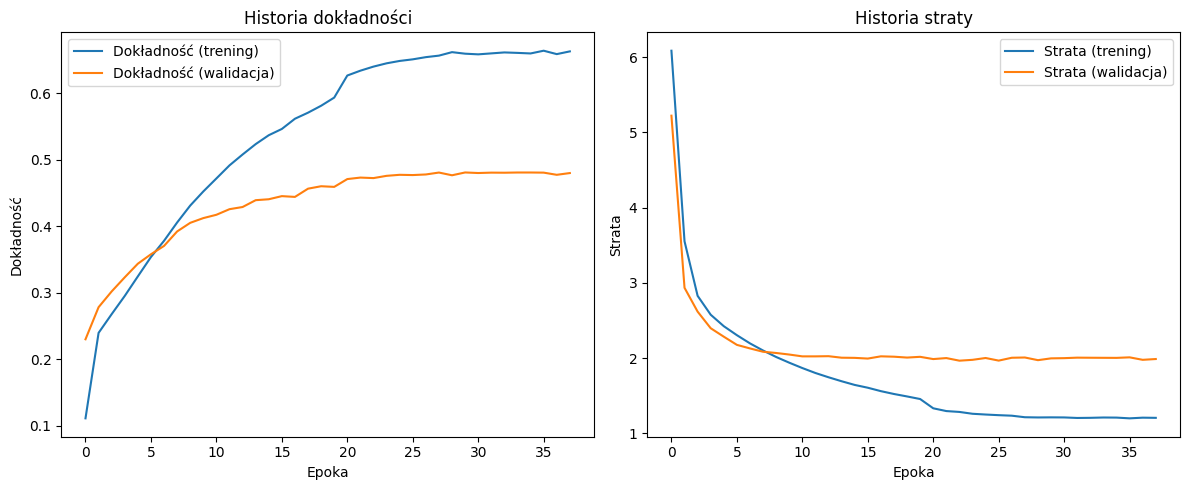

In [6]:
# Kod do wygenerowania wykresów po zakończeniu treningu
import matplotlib.pyplot as plt

def plot_history(history):
    # Wykres dokładności
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Dokładność (trening)')
    plt.plot(history.history['val_accuracy'], label='Dokładność (walidacja)')
    plt.title('Historia dokładności')
    plt.xlabel('Epoka')
    plt.ylabel('Dokładność')
    plt.legend()

    # Wykres straty
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Strata (trening)')
    plt.plot(history.history['val_loss'], label='Strata (walidacja)')
    plt.title('Historia straty')
    plt.xlabel('Epoka')
    plt.ylabel('Strata')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Po zakończeniu model.fit():
plot_history(history)